In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import time

In [3]:
import sncosmo

In [4]:
from lsst.sims.utils import ObservationMetaData
from lsst.sims.catalogs.measures.instance import InstanceCatalog

In [5]:
#The following is to get the object ids in the registry
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj

Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values


In [9]:
import rates

In [10]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(Om0=0.25, H0=73.)

In [11]:
TwinklesArea = np.radians(1.0/6.)**2 
AreaFactor = np.pi * (np.sqrt(2)*0.4)**2./(1./6.)**2

In [12]:
AreaFactor

36.191147369354432

In [11]:
# Requirement
# There should be 100 SN in the redshift range 0, 0.7 in teh Twinkles area in 1 year (season)

In [12]:
factor = 100./rates.numSN(0., 0.7, 70, cosmo, fieldArea=TwinklesArea, DeltaT=0.5, snrate=rates.snRate).sum();
print factor

131.740349077


In [13]:
binwidth = 0.05
zbins = np.arange(0., 1.2, binwidth);zbins

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15])

In [14]:
zup = np.arange(binwidth, 1.2 + binwidth, binwidth)
zmid = (zbins + zup ) /2.
print len(zbins)

24


In [15]:
# Numbers of Supernova in a circular region of size 0.4 * sqrt(2) in the sprinkled region over 10 years
snnum = factor*rates.numSN(0., 1.2+ binwidth, len(zbins), cosmo, AreaFactor* TwinklesArea, 10, snrate=rates.snRate)

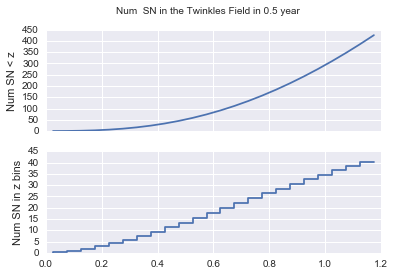

In [16]:
fig, ax = plt.subplots(2,1, sharex=True)
_ = ax[0].plot(zmid, factor*rates.numSN(0., 1.2 + binwidth, len(zbins), cosmo, 
                                 TwinklesArea, 0.5, snrate=rates.snRate).cumsum())

_ = ax[1].step(zmid, factor*rates.numSN(0., 1.2 + binwidth, len(zbins), cosmo, 
                                 TwinklesArea, 0.5, snrate=rates.snRate))
ax[0].set_ylabel('Num SN < z')
ax[1].set_ylabel('Num SN in z bins')
_ = fig.suptitle('Num  SN in the Twinkles Field in 0.5 year')

(array([   1.05412239,    7.30008054,   19.46694017,   37.10801177,
          59.71467839,   86.73952331,  117.61698208,  151.78102231,
         188.67962096,  227.78604028,  268.60708401,  310.68864052,
         353.61889189,  397.02959617,  440.59584396,  484.03466126,
         527.10278679,  569.59390187,  611.33554021,  652.18585626,
         692.03038791,  730.77891228,  768.3624625 ,  804.73054909]),
 array([ 0.        ,  0.04791667,  0.09583333,  0.14375   ,  0.19166667,
         0.23958333,  0.2875    ,  0.33541667,  0.38333333,  0.43125   ,
         0.47916667,  0.52708333,  0.575     ,  0.62291667,  0.67083333,
         0.71875   ,  0.76666667,  0.81458333,  0.8625    ,  0.91041667,
         0.95833333,  1.00625   ,  1.05416667,  1.10208333,  1.15      ]),
 <a list of 1 Patch objects>)

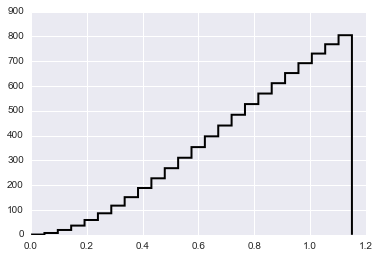

In [17]:
plt.hist(zbins, weights=snnum/AreaFactor, bins=24, histtype='step', alpha=1, lw=2, color='k')

## Get Galaxies on Fatboy

In [17]:
degConv = np.array([1., 1./60., 1./3600.])
raConv = degConv / 24.0 * 360.
centralRA = np.dot(np.array([3., 32., 30]), raConv) #03h 32m 30s
centralDec = np.dot(np.array([-28, 6., 0.]), degConv)
patchRadius = 0.4 * np.sqrt(2)

In [19]:
TwinklesObsMetaData = ObservationMetaData(boundType='circle',pointingRA=centralRA,pointingDec=centralDec,
                                          boundLength=patchRadius, mjd=49540.0)

In [20]:
galaxyTiled  = GalaxyTileObj()

/usr/local/manual/anaconda/lib/python2.7/site-packages/sqlalchemy/dialects/mssql/base.py:1294: SAWarning: Did not recognize type 'geography' of column 'geopoint'
  return fn(*arg, **kw)


In [21]:
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift', 'a_d', 'b_d', 'pa_disk']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e'}

In [22]:
TwinklesGalaxies = galCopy(galaxyTiled, obs_metadata=TwinklesObsMetaData)

In [ ]:
TwinklesGalaxies.write_catalog('TwinklesGalaxies.dat')

In [23]:
TwinkGalsdf = pd.read_csv('TwinklesGalaxies.dat', sep=',\s+', engine='python', index_col=0)

In [24]:
TwinkGalsdf['zbin'] = TwinkGalsdf.redshift // binwidth

In [25]:
TwinkGalsdf.zbin = TwinkGalsdf.zbin.astype(int)

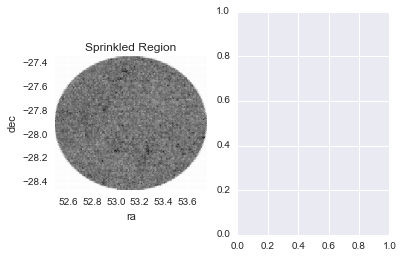

In [50]:
densfig, ax = plt.subplots(1, 2)
ax[0].hexbin(np.degrees(TwinkGalsdf.raJ2000.values), np.degrees(TwinkGalsdf.decJ2000.values))
ax[0].set_aspect('equal')
ax[0].set_ylabel('dec')
ax[0].set_xlabel('ra')
ax[0].set_title('Sprinkled Region')
densfig.savefig('Twinkles_Area.png')

In [29]:
zbinnedGals = TwinkGalsdf.groupby('zbin')

In [30]:
len(snnum), len(zmid)

(24, 24)

In [31]:
zSummary  = pd.DataFrame({'zbin' : np.array(zmid // binwidth, dtype=np.int), 
                          'NumSNperzBin': snnum})

In [32]:
# Astropy cosmology object for CatSim Cosmology
CatSimCosmo = FlatLambdaCDM(Om0=0.25, H0=73.)

alphaTwinkles = 0.11
betaTwinkles = -3.14
cdistTwinkles = [0., 0.1]
x1distTwinkles = [0, 1.]
MTwinkles = [-19.3, 0.15]



In [33]:
def assignIds(snwithHosts, maxval=100):
    snwithHosts['offset'] = 0
    sngroups = snwithHosts.groupby('galtileid')
    for host in (sngroups.count() > 0).index.values:
        sn = sngroups.get_group(host)
        idx  = sn.index
        snwithHosts.loc[idx, 'offset'] = np.arange(len(sn))
    return None

In [34]:
def assignSNHosts(galdf, numSN, seed):
    if seed is not None:
        np.random.seed(seed)
    sngalids = np.random.choice(galdf.index.values, numSN, replace=True)
    zvals = galdf.ix[sngalids,'redshift']
    df = pd.DataFrame({'galtileid': sngalids, 
                      'redshift' : zvals.values})
    return df

In [35]:
# Slow step: Takes about 20 mins
def assignSN(zbinnedGals, SNzSummary, binList=[0, 1], maxval=10, seed=42):
    
    dfs = []
    for idx in binList:
        galdf = zbinnedGals.get_group(idx)
        numSN = SNzSummary.NumSNperzBin[idx]
        if idx == 0 :
            snWithHosts = assignSNHosts(galdf, numSN, seed)
        else:
            snWithHosts = assignSNHosts(galdf, numSN, seed=None)
        assignIds(snWithHosts, maxval=maxval)
        dfs.append(snWithHosts)
    snvals = pd.concat(dfs)
    snvals['snid'] = snvals['galtileid'] *maxval + snvals['offset']
    return snvals

In [36]:
zSummary.zbin.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [38]:
assignStart = time.time()
snvals = assignSN(zbinnedGals, zSummary, binList=zSummary.zbin.values, maxval=100, seed=42)
assignEnd = time.time()

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [39]:
len(snvals)

307900

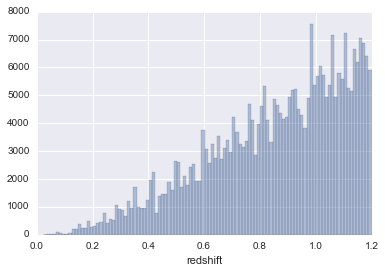

In [40]:
sns.distplot(snvals.redshift, rug=False, kde=False)

In [41]:
snvals.set_index(snvals['snid'], drop=True, verify_integrity=True, inplace=True)

In [42]:
snvals.query('redshift < 0.7').snid.size / 20.

4028.5

In [43]:
def assigSNParams(sntable, seed=42, cosmo=None, T0Min=0., T0Max=3650., 
                  MabsScatter= [-19.3, 0.15], cScatter=[0., 0.1], x1Scatter=[0., 1.], alpha=0.11, beta=-3.14 ):
    if seed is not None:
        np.random.seed(seed)
        
    model = sncosmo.Model(source='salt2')
    if cosmo is None:
        cosmo = FlatLambdaCDM(Om0=0.25, H0=73.)
        
    numSN = len(sntable)
    zvals = sntable.redshift.values
    cvals = np.random.normal(cScatter[0], cScatter[1], size=numSN)
    x1vals = np.random.normal(x1Scatter[0], x1Scatter[1], size=numSN)
    M  = np.random.normal(MabsScatter[0], MabsScatter[1], size=numSN)
    
    M += -alpha * x1vals - beta * cvals 
    t0 = np.random.uniform(T0Min, T0Max, size=numSN)
    x0 = np.zeros(numSN)
    mB = np.zeros(numSN)
    # Slow Step
    for i, Mabs in enumerate(M):
        model.set(z=zvals[i], c=cvals[i], x1=x1vals[i])
        model.set_source_peakabsmag(Mabs, 'bessellB', 'ab', cosmo=cosmo)
        x0[i] = model.get('x0')
        mB[i] = model.source.peakmag('bessellB', 'ab')
    sntable['t0'] = t0
    sntable['c'] = cvals
    sntable['x1'] = x1vals
    sntable['x0'] = x0
    sntable['mB'] = mB
    sntable['M'] = M
    
    print (alpha, beta, cScatter, x1Scatter, MabsScatter)
    

In [45]:

starttime = time.time()
assigSNParams(sntable=snvals, cosmo=CatSimCosmo, alpha=alphaTwinkles, beta=betaTwinkles, MabsScatter=MTwinkles, 
              seed=24)
endtime = time.time()



(0.11, -3.14, [0.0, 0.1], [0.0, 1.0], [-19.3, 0.15])


In [46]:
print endtime - starttime

315.075645924


In [47]:
def assignPositions(sntable, Galsdf, seed=42):

    radiansPerArcSec = (np.pi / 180.)* (1./60.)**2
    if seed is not None:
        np.random.seed(seed)
    
    r1 = np.random.normal(0., 1., sntable.snid.size)
    r2 = np.random.normal(0., 1., sntable.snid.size)
    
    sntable['raJ2000'] = Galsdf.ix[sntable.galtileid, 'raJ2000'].values
    sntable['decJ2000'] = Galsdf.ix[sntable.galtileid, 'decJ2000'].values
    sntable['a_d'] = Galsdf.ix[sntable.galtileid, 'a_d'].values * radiansPerArcSec
    sntable['b_d'] = Galsdf.ix[sntable.galtileid, 'b_d'].values * radiansPerArcSec

    # convert from degrees to radians
    sntable['theta'] = np.radians(Galsdf.ix[sntable.galtileid, 'pa_disk'].values)
    
    sntable['sndec'] = np.cos(-sntable['theta']) * sntable['a_d']* r1 + np.sin(-sntable['theta'])*sntable['b_d'] * r2
    sntable['snra'] =  - np.sin(-sntable['theta']) * sntable['a_d']*r1 + np.cos(-sntable['theta'])* sntable['b_d'] * r2
    sntable['snra'] += Galsdf.ix[sntable.galtileid, 'raJ2000'].values
    sntable['sndec'] += Galsdf.ix[sntable.galtileid, 'decJ2000'].values
    
    sntable['sndec'] = np.degrees(sntable['sndec'])
    sntable['snra'] = np.degrees(sntable['snra'])
    sntable['raJ2000'] = np.degrees(sntable['raJ2000'])
    sntable['decJ2000'] = np.degrees(sntable['decJ2000'])




In [48]:

assignPositions(snvals, TwinkGalsdf, seed=4 )

In [49]:
snvals.head()

galtileid  redshift  offset           snid           t0  \
snid                                                                       
6001014685800  60010146858    0.0452       0  6001014685800  2171.169132   
6000001337700  60000013377    0.0376       0  6000001337700  3393.144905   
6000067275900  60000672759    0.0410       0  6000067275900  3106.774493   
6001014687900  60010146879    0.0452       0  6001014687900  2495.557828   
6000635785100  60006357851    0.0404       0  6000635785100   492.882871   

                      c        x1        x0         mB          M    raJ2000  \
snid                                                                           
6001014685800  0.132921  0.163237  0.001343  17.677207 -18.743246  53.283190   
6000001337700 -0.077003  0.121939  0.004584  16.345182 -19.662862  53.471716   
6000067275900 -0.031628  0.405193  0.002616  16.953475 -19.248227  53.290667   
6001014687900 -0.099081 -1.440927  0.002169  17.163804 -19.256649  53.737013   
6000635785100 -0.107082  2.146382  0.004358  16.390759 -19.777931  52.967633   

                decJ2000       a_d       b_d     theta      sndec       snra  
snid                                                                          
6001014685800 -27.581455  0.000024  0.000020  1.765229 -27.581426  53.283265  
6000001337700 -28.124917  0.000013  0.000008  2.615606 -28.124875  53.472507  
6000067275900 -27.872414  0.000020  0.000017  0.214337 -27.873381  53.289702  
6001014687900 -27.971146  0.000024  0.000020  1.765229 -27.973330  53.737539  
6000635785100 -28.024174  0.000019  0.000017  2.232906 -28.023961  52.967234

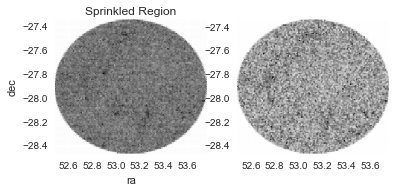

In [56]:
ax[1].hexbin(snvals.snra, snvals.sndec)
ax[1].set_aspect('equal')
densfig

In [ ]:
sns.distplot(snvals.t0)
             

In [63]:
snvals.query('t0 < 50').redshift.size/ AreaFactor

113.53605228552043

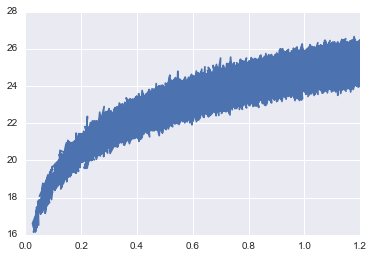

In [64]:
plt.plot(snvals.redshift, snvals.mB)

In [ ]:
snvals.query('redshift < 0.7 and t0 > 570 and t0 < 935').redshift.sum() / AreaFactor

In [ ]:
(snvals.index.values - snvals.galtileid * 100 ).max()

In [ ]:
snvals.head()

In [ ]:
60150 - 59580

In [ ]:
570 + 365


In [ ]:
snvals.to_csv('kraken_sim.csv')

In [ ]:
### OpSim

In [62]:
krakenvisits = pd.read_csv('/Users/rbiswas/doc/projects/LSST/Twinkles/code/SN_sims/SelectedKrakenVisits.csv')

In [13]:
from lsst.sims.photUtils import BandpassDict

In [14]:
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [15]:
from lsst.sims.catUtils.supernovae import SNObject

In [18]:
snobj = SNObject(ra=centralRA, dec=centralDec)

In [78]:
len(snvals)

307900

In [23]:
sntable = pd.read_csv('kraken_sim.csv'); print len(sntable)

307900


In [26]:
Twinkles = sntable.query('snra < 0.116 + @centralRA and snra > -0.116 + @centralRA').query('sndec < 0.116 + @centralDec and sndec > -0.116 + @centralDec')

In [30]:
len(Twinkles.query('redshift < 0.6'))/20.

117.8

In [44]:
from astropy.units import Unit
import os
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


In [45]:
model = sncosmo.Model(source='salt2-extended')

In [50]:
krakenvisits['filter'].values

array(['g', 'i', 'r', ..., 'r', 'y', 'z'], dtype=object)

In [ ]:
for index, row in Twinkles.iterrows():
    params = {'c':row['c'], 'x1':row['x1'], 'x0':row['x0'], 't0':row['t0']}
    snid = row['snid']
    model.set(**params)
    krakenvisits['mag_'+str(int(snid))] = model.bandmag(band=krakenvisits['filter'].values, magsys='ab',time=krakenvisits.expMJD)
    #flux = snobj.catsimBandFlux(krakenvisits.expMJD.iloc[0], lsst_bp[krakenvisits['filter'].iloc[0]])
    #err = snobj.catsimBandFluxError(krakenvisits.expMJD.iloc[0], lsst_bp[krakenvisits['filter'].iloc[0]], krakenvisits.fiveSigmaDepth.iloc[0],flux)
    #print flux , err




In [ ]:
krakenvisits.head()

In [55]:
fluxes

array([ 22.22875549,  21.80093767,  21.60959655, ...,  21.60959655,
        21.327428  ,  21.69497682])

In [ ]:
for index, row in snvals.iterrows():
    print row['c'], row['x1'], row['x0']


0.132921217265 0.163237310503 0.00134324944338
-0.0770033452005 0.121938624594 0.00458423909024
-0.0316280359621 0.4051929612 0.00261572818474
-0.0990810386641 -1.44092681042 0.00216857050456
-0.107081625562 2.14638240437 0.0043584618261
-0.143871327983 0.61372587034 0.00372457609783
0.056441685152 -0.0759817209299 0.00201504741285
0.0295721887622 -0.507085602649 0.0017032840449
-0.162640423331 -0.302711726181 0.00547231097186
0.0219565198748 -0.846710312099 0.00184988762381
0.0678804799025 -1.66785566094 0.00196112380102
0.188927273142 0.77954579756 0.00206872947192
0.0961538398678 -0.892872807275 0.00159338196629
0.0104011195684 -0.396418411332 0.0023411211246
-0.0481165317281 -1.3337944192 0.00194653362602
0.0850228531228 -0.322278617241 0.00236367197724
0.145342466641 -0.652863344368 0.00240565212589
0.105773743558 0.00314881338666 0.00111565291029
0.0165561607158 0.453234698955 0.00183754115361
0.051501837804 0.934226019949 0.00225142819541
-0.133693568578 -0.275354182356 0.004403

In [25]:
3.5 / 30.

0.11666666666666667